# La Liga Relevancy - Daniel Ceballos

### Libraries

In [ ]:
# Numerical Manipulation
import numpy as np
# Data Manipulation
import pandas as pd
# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from yellowbrick.model_selection import ValidationCurve
# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
# Extrem Gradient Boosting
from xgboost import XGBRegressor

### Processing Libraries

In [ ]:
# Feature Engineering
from sklearn.base import BaseEstimator, TransformerMixin
# Pipeline, OneHotEncoder & ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/work/ceba_train.csv')
df

match                    competition  \
0             Real Madrid - Granada 2:7                  Spain. LaLiga   
1             Sevilla - Real Madrid 1:2                  Spain. LaLiga   
2      Real Madrid - Rayo Vallecano 2:1                  Spain. LaLiga   
3            Valencia - Real Madrid 1:0                  Spain. LaLiga   
4     Manchester City - Real Madrid 4:0  Europe. UEFA Champions League   
..                                  ...                            ...   
89           Real Madrid - Espanyol 2:0                  Spain. LaLiga   
90  Borussia Dortmund - Real Madrid 1:3  Europe. UEFA Champions League   
91   Deportivo Alavés - Real Madrid 1:2                  Spain. LaLiga   
92      Real Sociedad - Real Madrid 1:3                  Spain. LaLiga   
93              Real Madrid - APOEL 3:0  Europe. UEFA Champions League   

       date      position  minutes_played  total_actions  \
0    6/4/23         LCMF3              57             79   
1   5/27/23    LWF, RCMF3             100            109   
2   5/24/23          RCMF              31             46   
3   5/21/23  LCMF3, RCMF3              64             78   
4   5/17/23           AMF              14             18   
..      ...           ...             ...            ...   
89  10/1/17          LCMF              10             15   
90  9/26/17          LCMF               2              4   
91  9/23/17   LDMF, RCMF3              73             82   
92  9/17/17           AMF              10              8   
93  9/13/17           AMF              22             27   

    total_actions_successful  total _actions_percent  goals  assists  ...  \
0                         56                      71      0        0  ...   
1                         82                      75      0        0  ...   
2                         37                      80      0        1  ...   
3                         58                      74      0        0  ...   
4                         13                      72      0        0  ...   
..                       ...                     ...    ...      ...  ...   
89                        11                      73      0        0  ...   
90                         2                      50      0        0  ...   
91                        61                      74      2        0  ...   
92                         6                      75      0        0  ...   
93                        23                      85      0        0  ...   

    aerial_duels  aerial_duels_won  aerial_duels_percent  interceptions  \
0              1                 0                     0              2   
1              0                 0                     0              3   
2              1                 0                     0              2   
3              0                 0                     0              0   
4              0                 0                     0              1   
..           ...               ...                   ...            ...   
89             0                 0                     0              0   
90             0                 0                     0              0   
91             0                 0                     0              2   
92             0                 0                     0              0   
93             0                 0                     0              0   

    losses  losses_own_half  losses_percent  recoveries  recoveries_opp_half  \
0       10                4              40           5                    3   
1       13                5              38           4                    1   
2        3                1              33           2                    0   
3       10                6              60           8                    5   
4        1                1             100           1                    0   
..     ...              ...             ...         ...                  ...   
89       1                0           

### Data Pre-processing

- 

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')

# Columns to drop
columns_to_drop = ['match', 'competition', 'date']

drop_columns_transformer = DropColumns(columns_to_drop)
df = drop_columns_transformer.transform(df)

- 

In [ ]:
class ConvertToFloat(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].astype(float)
        return X

# Columnas a convertir a tipo float
columns_to_convert = [
    'total _actions_percent', 'shots_percents', 'passes_percent',
    'long_passes_percent', 'crosses_percent', 'dribbles_percent', 
    'duels_percent', 'aerial_duels_percent', 'losses_percent', 
    'recoveries_percent'
]

# Crear una instancia de la clase ConvertToFloat
convert_to_float_transformer = ConvertToFloat(columns_to_convert)

# Aplicar el transformador al DataFrame df
df = convert_to_float_transformer.transform(df) 

In [ ]:
df.head(5)

position  minutes_played  total_actions  total_actions_successful  \
0         LCMF3              57             79                        56   
1    LWF, RCMF3             100            109                        82   
2          RCMF              31             46                        37   
3  LCMF3, RCMF3              64             78                        58   
4           AMF              14             18                        13   

   total _actions_percent  goals  assists  shots  shots_on_target  \
0                    71.0      0        0      0                0   
1                    75.0      0        0      0                0   
2                    80.0      0        1      1                1   
3                    74.0      0        0      0                0   
4                    72.0      0        0      1                1   

   shots_percents  ...  aerial_duels  aerial_duels_won  aerial_duels_percent  \
0             0.0  ...             1                 0                   0.0   
1             0.0  ...             0                 0                   0.0   
2           100.0  ...             1                 0                   0.0   
3             0.0  ...             0                 0                   0.0   
4           100.0  ...             0                 0                   0.0   

   interceptions  losses  losses_own_half  losses_percent  recoveries  \
0              2      10                4            40.0           5   
1              3      13                5            38.0           4   
2              2       3                1            33.0           2   
3              0      10                6            60.0           8   
4              1       1                1           100.0           1   

   recoveries_opp_half  recoveries_percent  
0                    3                60.0  
1                    1                25.0  
2                    0                 0.0  
3                    5                63.0  
4                    0                 0.0  

[5 rows x 36 columns]

In [ ]:
# Rows & Shapes
df.shape

(94, 36)

In [ ]:
# Looking for null or missing values
df.isnull().sum()

position                    0
minutes_played              0
total_actions               0
total_actions_successful    0
total _actions_percent      0
goals                       0
assists                     0
shots                       0
shots_on_target             0
shots_percents              0
xG                          0
passes                      0
passes_accurate             0
passes_percent              0
long_passes                 0
long_passes_accurate        0
long_passes_percent         0
crosses                     0
crosses_accurate            0
crosses_percent             0
dribbles                    0
dribbles_successful         0
dribbles_percent            0
duels                       0
duels_won                   0
duels_percent               0
aerial_duels                0
aerial_duels_won            0
aerial_duels_percent        0
interceptions               0
losses                      0
losses_own_half             0
losses_percent              0
recoveries

In [ ]:
# class FillMissing(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X.ffill()

# # Crear una instancia de la clase FillMissing
# fill_missing_transformer = FillMissing()

# # Aplicar el transformador al DataFrame df
# df = fill_missing_transformer.transform(df)

### Position Relevancy

In [ ]:
position_counts = df['position'].value_counts()
print(position_counts)

top_three_positions = df['position'].value_counts().head(3)
print(top_three_positions)

# To get the average (mean) frequency of the top 3 positions
mean_top_three = top_three_positions.mean()
print(mean_top_three)

LCMF3                 31
RCMF3                 15
LCMF                  13
AMF                    6
RCMF                   3
LWF                    3
LW                     3
LDMF                   3
AMF, LW                2
LCMF, LCMF3            2
LDMF, RCMF3            1
RCMF, RCMF3            1
LWF, RCMF3             1
LDMF, RDMF             1
LCMF3, RCMF3           1
LCMF3, RWF             1
AMF, LDMF              1
LCMF3, LWF             1
LCMF, RCMF3            1
LAMF, LCMF3, RCMF3     1
DMF, RDMF              1
DMF                    1
RWF                    1
Name: position, dtype: int64
LCMF3    31
RCMF3    15
LCMF     13
Name: position, dtype: int64
19.666666666666668


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

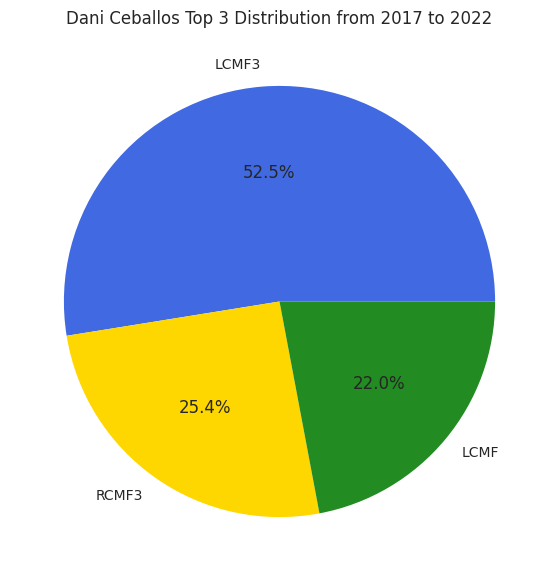

In [ ]:
proportions = top_three_positions / top_three_positions.sum()

colors = ['royalblue', 'gold', 'forestgreen']


plt.figure(figsize=(10,7))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=colors)
plt.title("Dani Ceballos Top 3 Distribution from 2017 to 2022")
plt.rcParams['font.family'] = 'Arial'
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

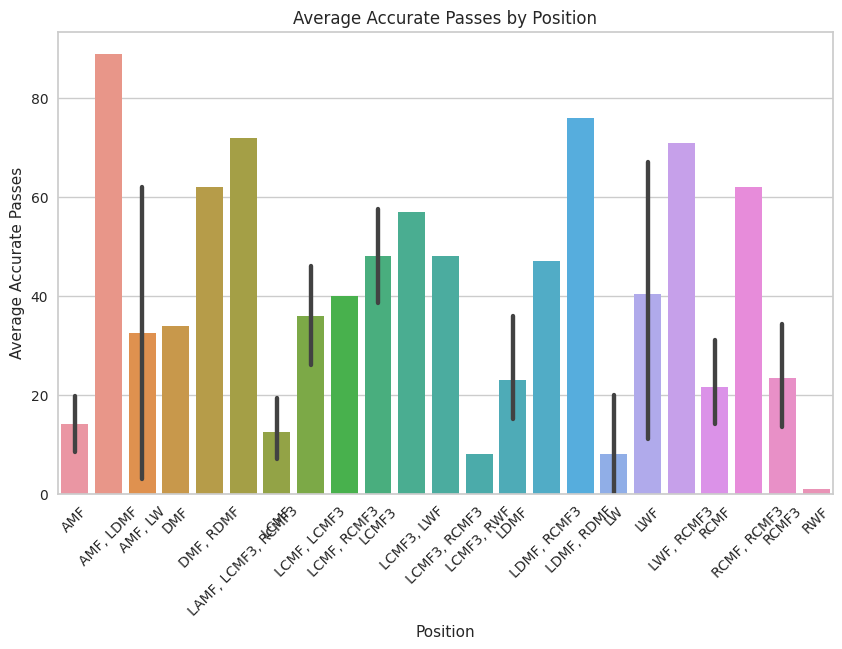

In [ ]:
df['position'] = df['position'].astype('category')  

# Creating a barplot to show the relationship between 'position' and 'passes_accurate'
plt.figure(figsize=(10, 6))  # Setting the size of the plot
sns.barplot(x='position', y='passes_accurate', data=df)  # Creating a barplot

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.title('Average Accurate Passes by Position')  # Setting the title of the plot
plt.xlabel('Position')  # Setting the label for the x-axis
plt.ylabel('Average Accurate Passes')  # Setting the label for the y-axis
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.rcParams['font.family'] = 'Arial'
plt.show()  # Displaying the plot

### Average Minutes Played

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

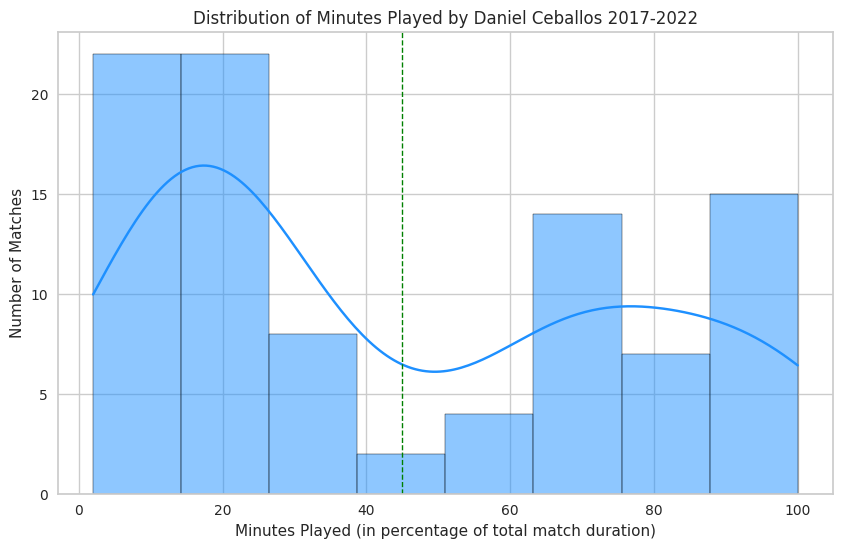

Dani Ceballos played on average 44.93617021276596 minutes per match.


In [ ]:
average_minutes_played = df['minutes_played'].mean()

# Plot the distribution of minutes played
plt.figure(figsize=(10, 6))
sns.histplot(df['minutes_played'], kde=True, color='dodgerblue')
plt.axvline(average_minutes_played, color='green', linestyle='dashed', linewidth=1)
plt.title('Distribution of Minutes Played by Daniel Ceballos 2017-2022')
plt.xlabel('Minutes Played (in percentage of total match duration)')
plt.ylabel('Number of Matches')
plt.show()

print(f"Dani Ceballos played on average {average_minutes_played} minutes per match.")

### Interceptions

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

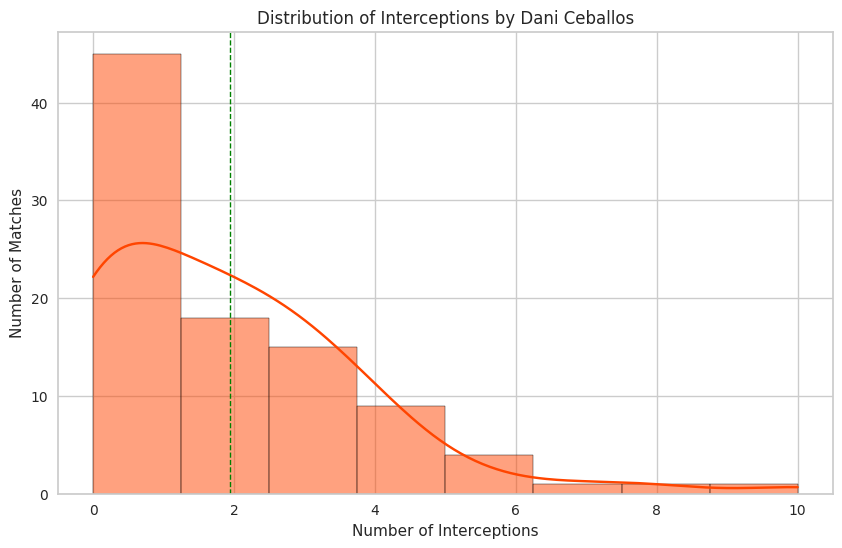

In [ ]:
# Calculate the average interceptions
average_interceptions = df['interceptions'].mean()

# Find the minimum and maximum interceptions
min_interceptions = df['interceptions'].min()
max_interceptions = df['interceptions'].max()

# Print out the results
print(f"Dani Ceballos has an average of {average_interceptions} interceptions per match.")
print(f"The minimum interceptions in a match by Dani Ceballos is {min_interceptions}.")
print(f"The maximum interceptions in a match by Dani Ceballos is {max_interceptions}.")

# Plot the distribution of interceptions
plt.figure(figsize=(10, 6))
sns.histplot(df['interceptions'], kde=True, color='orangered')
plt.axvline(average_interceptions, color='green', linestyle='dashed', linewidth=1)
plt.title('Distribution of Interceptions by Dani Ceballos')
plt.xlabel('Number of Interceptions')
plt.ylabel('Number of Matches')
plt.show()

# Exploratory Data Analysis

### Pearson's Method Heatmap

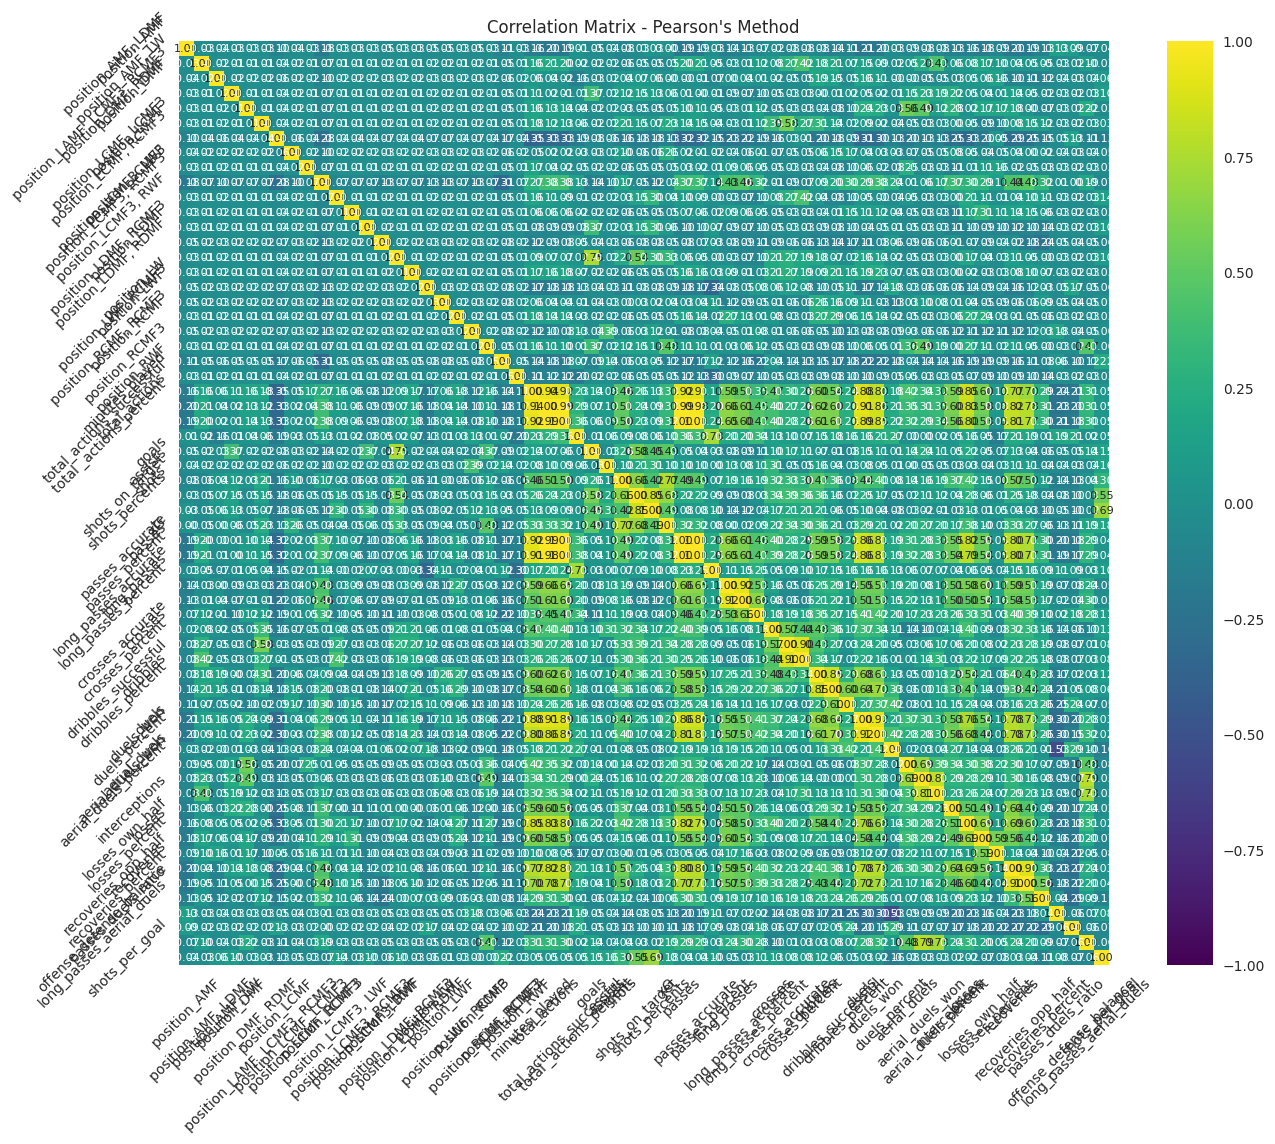

In [ ]:
# Calculating the Pearson correlation matrix
pearson_corr_matrix = df.corr(method='pearson')

# Creating a heatmap with the Pearson correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(pearson_corr_matrix, annot=True, fmt=".2f", cmap='viridis', vmax=1, vmin=-1, annot_kws={"size": 8})
plt.title("Correlation Matrix - Pearson's Method")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Spearman's  Method Heatmap

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

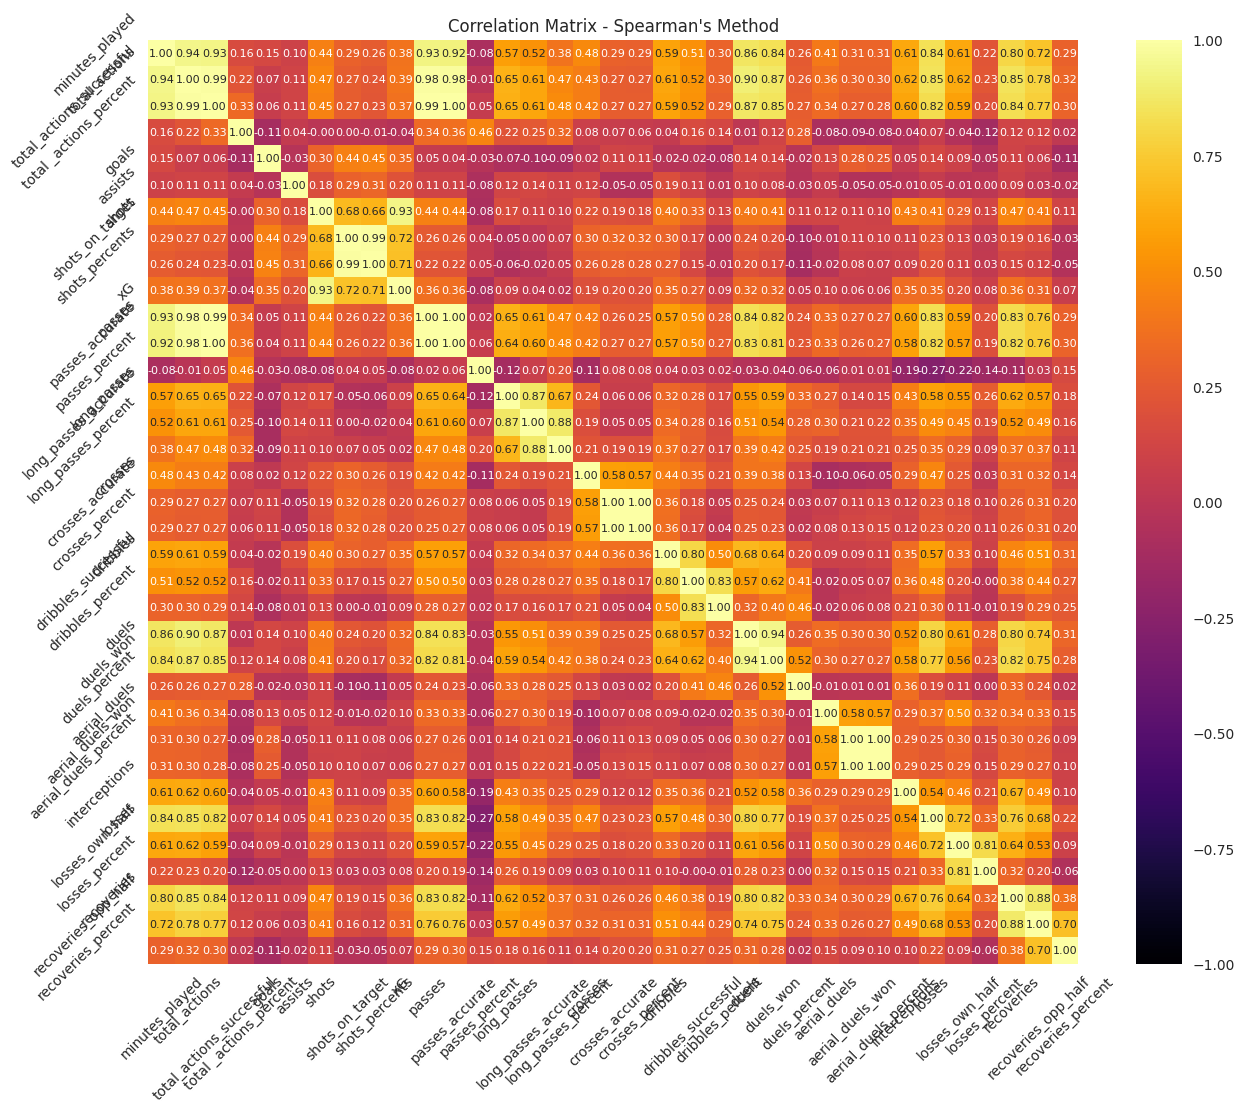

In [ ]:
# Calculating the correlation matrix using Spearman's method
corr_matrix = df.corr(method='spearman')

# Adjusting the figure size for better readability
plt.figure(figsize=(15, 12))  # Increase figure size
plt.rcParams['font.family'] = 'Arial'
# Creating a heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='inferno', vmax=1, vmin=-1, annot_kws={"size": 8}) 

plt.title("Correlation Matrix - Spearman's Method")

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=45)  # Rotate y-axis labels for better readability
plt.show()

### Dispersion Matrix

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

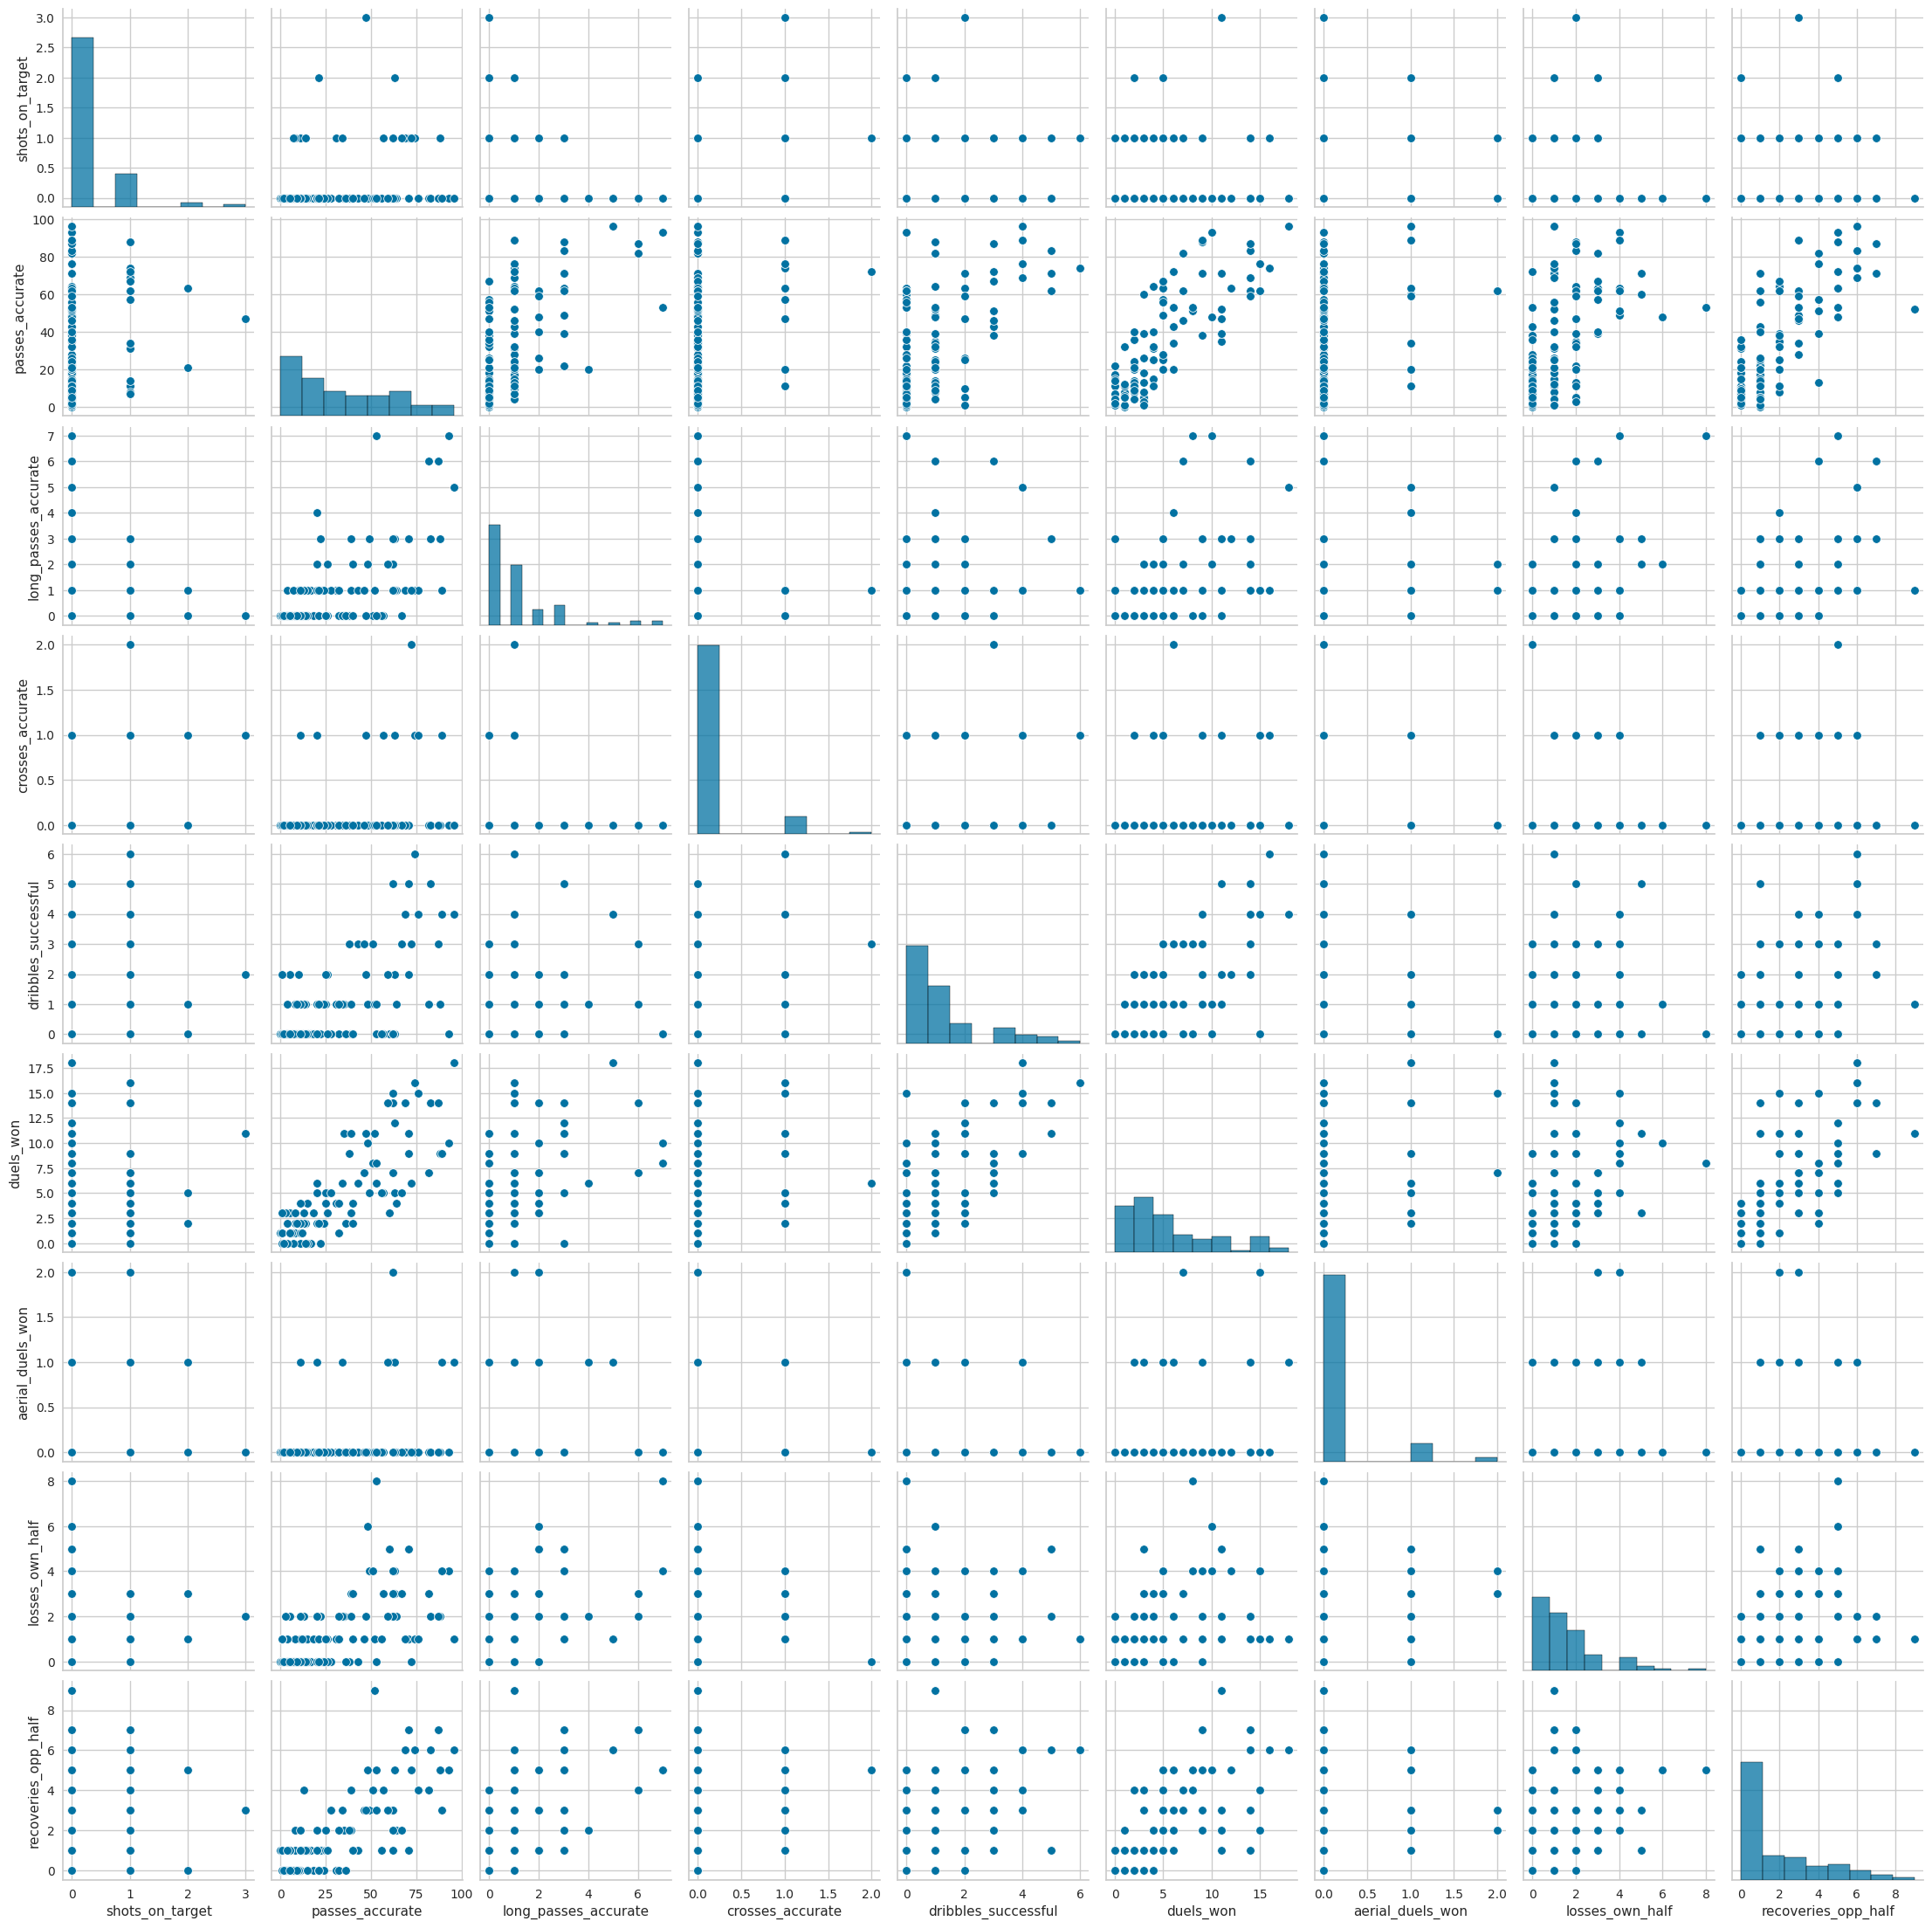

In [ ]:
selected_columns = [
    'shots_on_target', 'passes_accurate', 
    'long_passes_accurate', 'crosses_accurate', 'dribbles_successful', 
    'duels_won', 'aerial_duels_won', 'losses_own_half', 'recoveries_opp_half'
]
subset_df = df[selected_columns]

# Dispersion Matrix (PairPlot)
sns.pairplot(subset_df, diag_kind='hist')

plt.show()

In [ ]:
# Applying OneHotEncoding
column_to_encode = ['position']

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), column_to_encode)
    ],
    remainder='passthrough'  # Mantener el resto de las columnas sin cambios
)

# Aplicar el ColumnTransformer al DataFrame
transformed_data = preprocessor.fit_transform(df)

# Crear un DataFrame a partir de los datos transformados
# Obtener los nombres de las nuevas columnas OneHotEncoded
new_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(column_to_encode)
# Combinar los nombres de las nuevas columnas con las columnas existentes (excluyendo 'position')
all_columns = list(new_columns) + [col for col in df.columns if col not in column_to_encode]

# Crear el nuevo DataFrame
df = pd.DataFrame(transformed_data, columns=all_columns)

In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(df[col])):
        print(f"Infinites found in {col}")

# Applying Feature Engineering

In [ ]:
df.head(5)

position_AMF  position_AMF, LDMF  position_AMF, LW  position_DMF  \
0           0.0                 0.0               0.0           0.0   
1           0.0                 0.0               0.0           0.0   
2           0.0                 0.0               0.0           0.0   
3           0.0                 0.0               0.0           0.0   
4           1.0                 0.0               0.0           0.0   

   position_DMF, RDMF  position_LAMF, LCMF3, RCMF3  position_LCMF  \
0                 0.0                          0.0            0.0   
1                 0.0                          0.0            0.0   
2                 0.0                          0.0            0.0   
3                 0.0                          0.0            0.0   
4                 0.0                          0.0            0.0   

   position_LCMF, LCMF3  position_LCMF, RCMF3  position_LCMF3  ...  \
0                   0.0                   0.0             1.0  ...   
1                   0.0                   0.0             0.0  ...   
2                   0.0                   0.0             0.0  ...   
3                   0.0                   0.0             0.0  ...   
4                   0.0                   0.0             0.0  ...   

   aerial_duels  aerial_duels_won  aerial_duels_percent  interceptions  \
0           1.0               0.0                   0.0            2.0   
1           0.0               0.0                   0.0            3.0   
2           1.0               0.0                   0.0            2.0   
3           0.0               0.0                   0.0            0.0   
4           0.0               0.0                   0.0            1.0   

   losses  losses_own_half  losses_percent  recoveries  recoveries_opp_half  \
0    10.0              4.0            40.0         5.0                  3.0   
1    13.0              5.0            38.0         4.0                  1.0   
2     3.0              1.0            33.0         2.0                  0.0   
3    10.0              6.0            60.0         8.0                  5.0   
4     1.0              1.0           100.0         1.0                  0.0   

   recoveries_percent  
0                60.0  
1                25.0  
2                 0.0  
3                63.0  
4                 0.0  

[5 rows x 58 columns]

### Step - 1 (Setting New Features)

In [ ]:
df['passes_duels_ratio'] = df['passes_accurate'] / df['duels_won'].replace(0, 0.01)
df['offense_defense_balance'] = df['dribbles_successful'] / df['recoveries'].replace(0, 0.01)
df['long_passes_aerial_duels'] = df['long_passes_accurate'] * df['aerial_duels_won']

- Relationship between Passing Effectiveness and Duels Won: This feature could explore whether players who win more duels also tend to have greater passing accuracy, indicating a combination of physical and technical skills.

- Balance between Offensive and Defensive Actions: This feature measures the balance between offensive (represented by successful dribbles) and defensive (represented by recoveries) skills. A higher value suggests a bias toward offensive skills, while a lower value indicates a tendency toward defensive actions. It is a way to evaluate a player's playing style and contributions.

- Interaction between Long Passes and Air Duels: This feature explores the interaction between the ability to execute accurate long passes and performance in aerial duels. It's an exciting combination because it links a technical skill (accurate long passes) with a physical skill (winning aerial duels). A high value in this metric can indicate a player who is effective in both the aerial game and long-range ball distribution, which is valuable, especially for certain positions such as central defenders or defensive midfielders.

In [ ]:
# Not Zero-Division Error
df['xG'] = df['xG'].apply(lambda x: max(x, 0.01))

# Calculting  feature 'shots_per_goal'
df['shots_per_goal'] = df['shots_on_target'] / df['xG']

- Causality on Shots-per-Goal: This feature measures the balance between offensive (represented by successful dribbles) and defensive (represented by recoveries) skills. A higher value suggests a bias toward offensive skills, while a lower value indicates a tendency toward defensive actions. It is a way to evaluate a player's playing style and contributions.

In [ ]:
for col in df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(df[col])):
        print(f"Infinites found in {col}")

### Step - 2 (Imputing Process)

In [ ]:
from sklearn.impute import SimpleImputer

# Invoking & storage theSimpleImputer
imputer = SimpleImputer(strategy='median')
# Applying on DataFrame
df_imputed = imputer.fit_transform(df)

# Setting the DataFrame
df = pd.DataFrame(df_imputed, columns=df.columns)

- Process Verification

In [ ]:
# Checking Changes
print(df.head())

   position_AMF  position_AMF, LDMF  position_AMF, LW  position_DMF  \
0           0.0                 0.0               0.0           0.0   
1           0.0                 0.0               0.0           0.0   
2           0.0                 0.0               0.0           0.0   
3           0.0                 0.0               0.0           0.0   
4           1.0                 0.0               0.0           0.0   

   position_DMF, RDMF  position_LAMF, LCMF3, RCMF3  position_LCMF  \
0                 0.0                          0.0            0.0   
1                 0.0                          0.0            0.0   
2                 0.0                          0.0            0.0   
3                 0.0                          0.0            0.0   
4                 0.0                          0.0            0.0   

   position_LCMF, LCMF3  position_LCMF, RCMF3  position_LCMF3  ...  losses  \
0                   0.0                   0.0             1.0  ...    10.0   
1 

# Machine Learning Models

### Random Forest with Scikit-Learn

In [ ]:
from sklearn.ensemble import RandomForestRegressor

target = 'passes'

# Splitting the dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    print("There are NaN or infinite values en X_train")
if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    print("There are NaN or infinite values en X_test")

In [ ]:
# Creating a custom transformer to handle infinite values
def replace_inf(X):
    X = np.where(np.isinf(X), np.nan, X)
    return X

Best parameters:  {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best score (negative MSE):  -74.0984


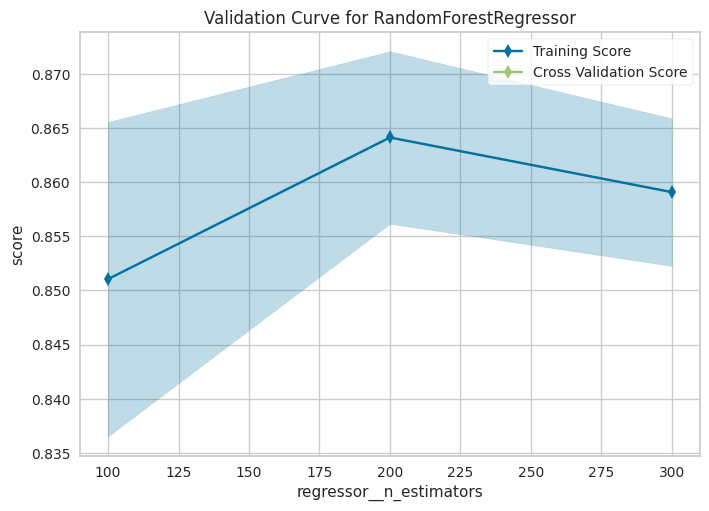

In [ ]:
# Building the pipeline
pipeline = Pipeline([
    ('handle_inf', FunctionTransformer(replace_inf, validate=False)),  # Handle infinite values
    ('imputer', SimpleImputer(strategy='median')),     # Impute missing values
    ('regressor', RandomForestRegressor(random_state=42))   # Regressor - Random Forest
])

# Define the hyperparameter space for grid search
param_grid = {
    'regressor__n_estimators': [200, 300, 500],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt'],
    # 'regressor__bootstrap': [True, False]  # Optional
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


# Best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score (negative MSE): ", grid_search.best_score_)

# Validation curves with Yellowbrick
val_curve = ValidationCurve(
    pipeline, param_name="regressor__n_estimators",  # Model and parameter to vary
    param_range=[100, 200, 300], cv=5, scoring="r2"  # Range of parameter values and scoring metric
)
val_curve.fit(X_train, y_train)  # Fitting the model
val_curve.show()  # Display the validation curve
plt.show()

### Adjusted Forest

In [ ]:
# Define the model with the best hyperparameters identified from GridSearchCV
best_model = RandomForestRegressor(
    max_depth=10,
    max_features='auto',  
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42  
)

# Train the model using the full training set
best_model.fit(X_train, y_train)

# Evaluate the model using the test set
r2_score = best_model.score(X_test, y_test)
print(f'R^2 score on the test set: {r2_score}')

R^2 score on the test set: 0.988231391230142


- Last Random Forest Regressor Ensemble:

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

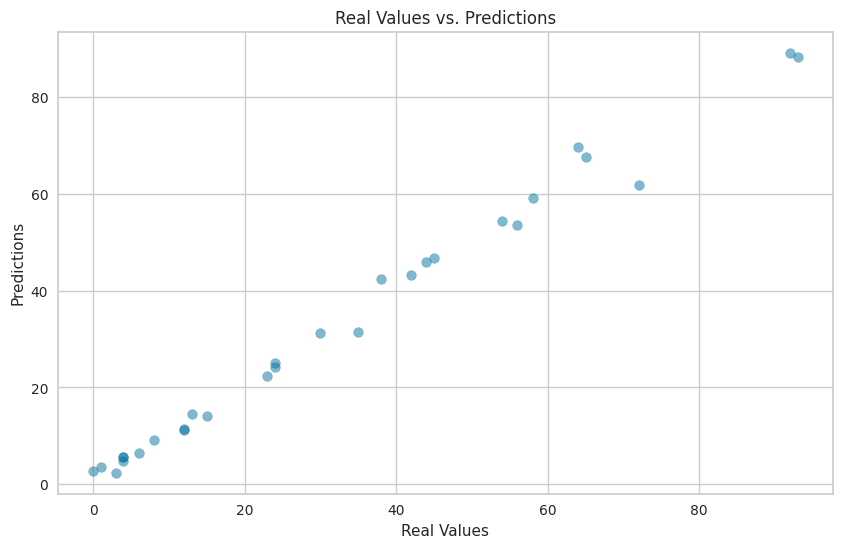

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

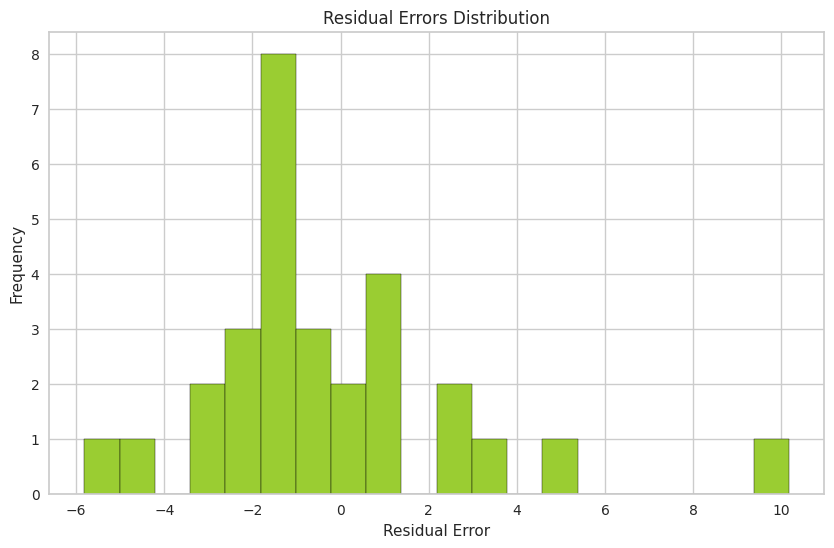

In [ ]:
target = 'passes'

# Splitting the dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Model Training
best_model = RandomForestRegressor(
    max_depth=10,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

best_model.fit(X_train, y_train)

# Model Evaluation
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R^2 score on the test set: {r2}')
print(f'Mean Squared Error on the test set: {mse}')

# Model Visulization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Real Values vs. Predictions')
plt.show()

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.hist(residuals, bins=20, color='yellowgreen',edgecolor='black')
plt.xlabel('Residual Error')
plt.ylabel('Frequency')
plt.title('Residual Errors Distribution')
plt.show()

- 

- 

### XGBoost Regressor

In [ ]:
# DataFrame Mandatory Copy
dfx = df.copy()
dfx

position_AMF  position_AMF, LDMF  position_AMF, LW  position_DMF  \
0            0.0                 0.0               0.0           0.0   
1            0.0                 0.0               0.0           0.0   
2            0.0                 0.0               0.0           0.0   
3            0.0                 0.0               0.0           0.0   
4            1.0                 0.0               0.0           0.0   
..           ...                 ...               ...           ...   
89           0.0                 0.0               0.0           0.0   
90           0.0                 0.0               0.0           0.0   
91           0.0                 0.0               0.0           0.0   
92           1.0                 0.0               0.0           0.0   
93           1.0                 0.0               0.0           0.0   

    position_DMF, RDMF  position_LAMF, LCMF3, RCMF3  position_LCMF  \
0                  0.0                          0.0            0.0   
1                  0.0                          0.0            0.0   
2                  0.0                          0.0            0.0   
3                  0.0                          0.0            0.0   
4                  0.0                          0.0            0.0   
..                 ...                          ...            ...   
89                 0.0                          0.0            1.0   
90                 0.0                          0.0            1.0   
91                 0.0                          0.0            0.0   
92                 0.0                          0.0            0.0   
93                 0.0                          0.0            0.0   

    position_LCMF, LCMF3  position_LCMF, RCMF3  position_LCMF3  ...  losses  \
0                    0.0                   0.0             1.0  ...    10.0   
1                    0.0                   0.0             0.0  ...    13.0   
2                    0.0                   0.0             0.0  ...     3.0   
3                    0.0                   0.0             0.0  ...    10.0   
4                    0.0                   0.0             0.0  ...     1.0   
..                   ...                   ...             ...  ...     ...   
89                   0.0                   0.0             0.0  ...     1.0   
90                   0.0                   0.0             0.0  ...     1.0   
91                   0.0                   0.0             0.0  ...    10.0   
92                   0.0                   0.0             0.0  ...     1.0   
93                   0.0                   0.0             0.0  ...     3.0   

    losses_own_half  losses_percent  recoveries  recoveries_opp_half  \
0               4.0            40.0         5.0                  3.0   
1               5.0            38.0         4.0                  1.0   
2               1.0            33.0         2.0                  0.0   
3               6.0            60.0         8.0                  5.0   
4               1.0           100.0         1.0                  0.0   
..              ...             ...         ...                  ...   
89              0.0             0.0         0.0                  0.0   
90              0.0             0.0         0.0                  0.0   
91              2.0            20.0         7.0                  3.0   
92              0.0             0.0         1.0                  0.0   
93              0.0             0.0         0.0                  0.0   

    recoveries_percent  passes_duels_ratio  offense_defense_balance  \
0                 60.0            9.800000                 0.200000   
1                 25.0            6.454545                 1.250000   
2                  0.0            7.750000                 0.500000   
3                 63.0            4.800000                 0.125000   
4                  0.0           11.000000                 0.000000   
..                 ...                 ...                

In [ ]:
from sklearn.model_selection import train_test_split

# Setting New DataFrame
X = dfx.drop('passes', axis=1)
y = dfx['passes']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

- First Approaches

In [ ]:
from xgboost import XGBRegressor

# Configuración del pipeline
pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror'))
])

In [ ]:
from sklearn.model_selection import GridSearchCV

# Configuration of parameters for search
parameters = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    # Other parameters
}

grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)

# Extracting the best score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3}
Best Score: 0.9728294321694557


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

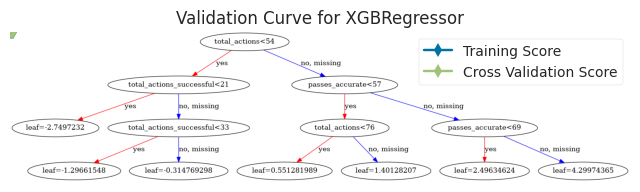

In [ ]:
from yellowbrick.model_selection import ValidationCurve
import xgboost as xgb

# Visualization of the tree
xgb.plot_tree(grid_search.best_estimator_['xgb'], num_trees=0)

# Validation Curve
viz = ValidationCurve(
    XGBRegressor(objective='reg:squarederror'), param_name="max_depth",
    param_range=[3, 5, 7], cv=3, scoring="r2"
)
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

MSE: 9.311840174056545
R^2: 0.9873309321733239


- Regressor Model once again but optimized!

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Rebuilding the model with the identified best hyperparameters
best_learning_rate = 0.1
best_max_depth = 3

# Setting up the pipeline with the optimized XGBRegressor
optimized_pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', 
                         learning_rate=best_learning_rate, 
                         max_depth=best_max_depth))
])

# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Predicting on the test data
y_pred = optimized_pipeline.predict(X_test)

# Evaluating the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 9.311840174056545
R^2 Score: 0.9873309321733239


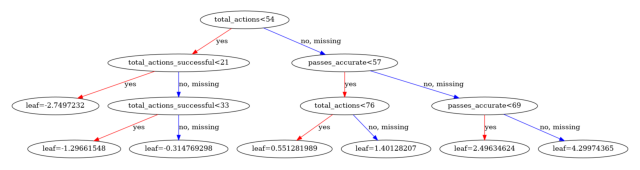

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

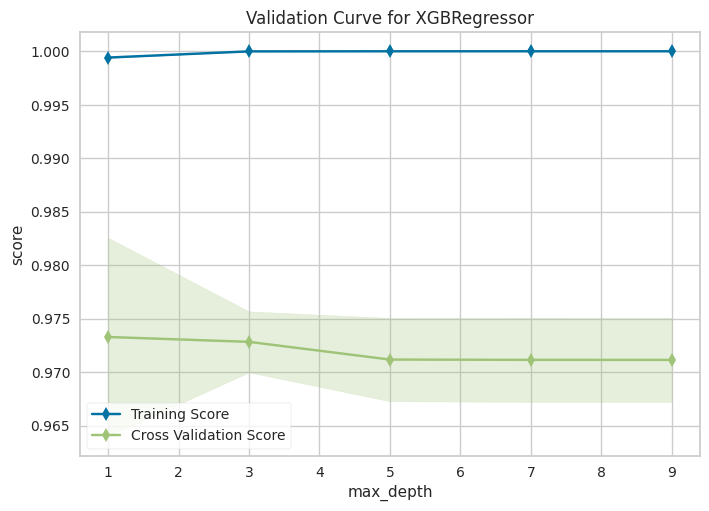

In [ ]:
# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Visualizing the first tree of the model
xgb_model = optimized_pipeline.named_steps['xgb']
xgb.plot_tree(xgb_model, num_trees=0)
plt.show()

# Creating a Validation Curve
# Here, we are using 'max_depth' as the parameter for the validation curve.
# You can change this to another parameter if desired.
viz = ValidationCurve(
    XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate),
    param_name="max_depth",
    param_range=[1, 3, 5, 7, 9],  # Adjust this range based on your needs
    cv=3,
    scoring="r2"
)

viz.fit(X_train, y_train)
viz.show()
plt.show()

# Test Data

In [ ]:
# Setting New DataFrame
test_df = pd.read_csv('/work/ceba_test.csv')
test_df

match    competition      date      position  \
0  Deportivo Alavés - Real Madrid 0:1  Spain. LaLiga  12/21/23            LW   
1        Real Madrid - Villarreal 4:1  Spain. LaLiga  12/17/23            LW   
2        Real Betis - Real Madrid 1:1  Spain. LaLiga   12/9/23    LAMF, LCMF   
3           Real Madrid - Granada 2:0  Spain. LaLiga   12/2/23            CF   
4             Cádiz - Real Madrid 0:3  Spain. LaLiga  11/26/23  LCMF, LW, RW   
5           Real Madrid - Osasuna 4:0  Spain. LaLiga   10/7/23         LCMF3   
6            Girona - Real Madrid 0:3  Spain. LaLiga   9/30/23            LW   
7        Real Madrid - Las Palmas 2:0  Spain. LaLiga   9/27/23      LW, RCMF   

   minutes_played  total_actions  total_actions_successful  \
0               2              1                         0   
1              16             12                        10   
2              28             32                        20   
3              24             20                        18   
4              27             28                        19   
5              22             25                        18   
6              25             28                        22   
7              36             49                        42   

   total_actions_percent  goals  assists  ...  aerial_duels  aerial_duels_won  \
0                      0      0        0  ...             0                 0   
1                     83      0        0  ...             0                 0   
2                     63      0        0  ...             0                 0   
3                     90      0        0  ...             1                 0   
4                     68      0        0  ...             0                 0   
5                     72      0        0  ...             0                 0   
6                     79      0        0  ...             0                 0   
7                     86      0        0  ...             0                 0   

   aerial_duels_percent  interceptions  losses  losses_own_half  \
0                     0              0       1                0   
1                     0              0       1                0   
2                     0              2       6                2   
3                     0              1       0                0   
4                     0              1       1                0   
5                     0              0       3                0   
6                     0              1       3                2   
7                     0              1       1                1   

   losses_percent  recoveries  recoveries_opp_half  recoveries_percent  
0               0           0                    0                   0  
1               0           0                    0                   0  
2              33           4                    3                  75  
3               0           3                    1                  33  
4               0           1                    1                 100  
5               0           0                    0                   0  
6              67           3                    1                  33  
7             100           7                    5                  71  

[8 rows x 39 columns]

In [ ]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, test_columns_to_drop):
        self.test_columns_to_drop = test_columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.test_columns_to_drop, errors='ignore')

# Columns to drop
test_columns_to_drop = ['match', 'competition', 'date']

drop_columns_transformer = DropColumns(test_columns_to_drop)
test_df = drop_columns_transformer.transform(test_df)

In [ ]:
class ConvertToFloat(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].astype(float)
        return X

# Columnas a convertir a tipo float
columns_to_convert = [
    'total_actions_percent', 'shots_percent', 'passes_percent',
    'long_passes_percent', 'crosses_percent', 'dribbles_percent', 
    'duels_percent', 'aerial_duels_percent', 'losses_percent', 
    'recoveries_percent'
]

# Crear una instancia de la clase ConvertToFloat
convert_to_float_transformer = ConvertToFloat(columns_to_convert)

# Aplicar el transformador al DataFrame df
test_df = convert_to_float_transformer.transform(test_df)

In [ ]:
# Rows & Shapes
test_df.shape

(8, 36)

In [ ]:
# Looking for null or missing values
df.isnull().sum()

position_AMF                0
position_AMF, LDMF          0
position_AMF, LW            0
position_DMF                0
position_DMF, RDMF          0
                           ..
recoveries_percent          0
passes_duels_ratio          0
offense_defense_balance     0
long_passes_aerial_duels    0
shots_per_goal              0
Length: 62, dtype: int64

### Test - La Liga Position Relevancy

In [ ]:
position_counts = test_df['position'].value_counts()
print(position_counts)

top_three_positions = test_df['position'].value_counts().head(3)
print(top_three_positions)

# To get the average (mean) frequency of the top 3 positions
mean_top_three = top_three_positions.mean()
print(mean_top_three)

LW              2
CF              1
LW, RCMF        1
LCMF, LW, RW    1
LCMF3           1
LAMF, LCMF      1
0               1
Name: position, dtype: int64
LW          2
CF          1
LW, RCMF    1
Name: position, dtype: int64
1.3333333333333333


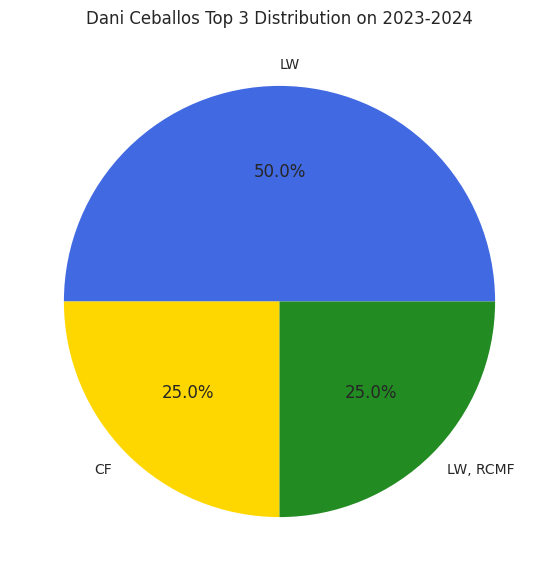

In [ ]:
proportions = top_three_positions / top_three_positions.sum()

colors = ['royalblue', 'gold', 'forestgreen']


plt.figure(figsize=(10,7))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=colors)
plt.title("Dani Ceballos Top 3 Distribution on 2023-2024")
plt.show()

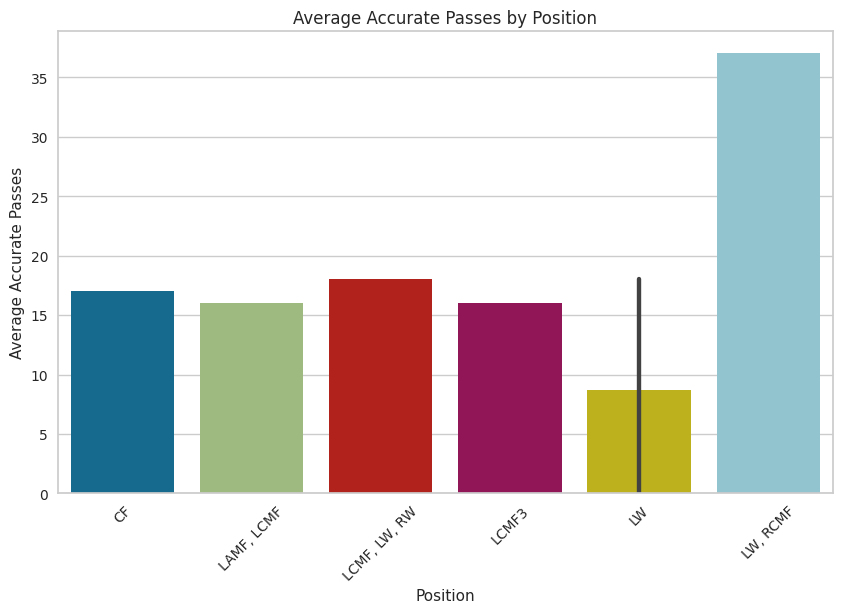

In [ ]:
test_df['position'] = test_df['position'].astype('category')  

# Creating a barplot to show the relationship between 'position' and 'passes_accurate'
plt.figure(figsize=(10, 6))  # Setting the size of the plot
sns.barplot(x='position', y='passes_accurate', data=test_df)  # Creating a barplot

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.title('Average Accurate Passes by Position')  # Setting the title of the plot
plt.xlabel('Position')  # Setting the label for the x-axis
plt.ylabel('Average Accurate Passes')  # Setting the label for the y-axis
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.show()  

### Test - AVG Minutes Played

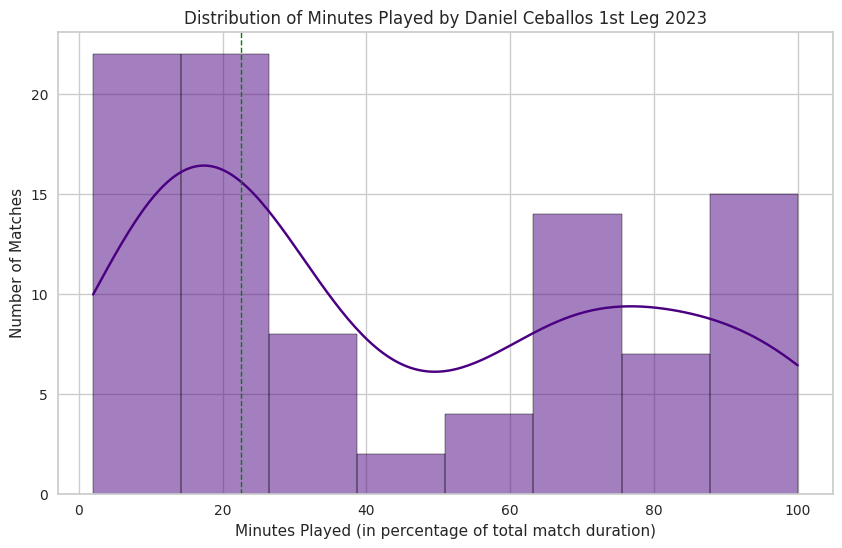

Dani Ceballos played on average 22.5 minutes per match.


In [ ]:
average_minutes_played = test_df['minutes_played'].mean()

# Plot the distribution of minutes played
plt.figure(figsize=(10, 6))
sns.histplot(df['minutes_played'], kde=True, color='indigo')
plt.axvline(average_minutes_played, color='green', linestyle='dashed', linewidth=1)
plt.title('Distribution of Minutes Played by Daniel Ceballos 1st Leg 2023')
plt.xlabel('Minutes Played (in percentage of total match duration)')
plt.ylabel('Number of Matches')
plt.show()

print(f"Dani Ceballos played on average {average_minutes_played} minutes per match.")

### Test - La Liga (E.D.A)

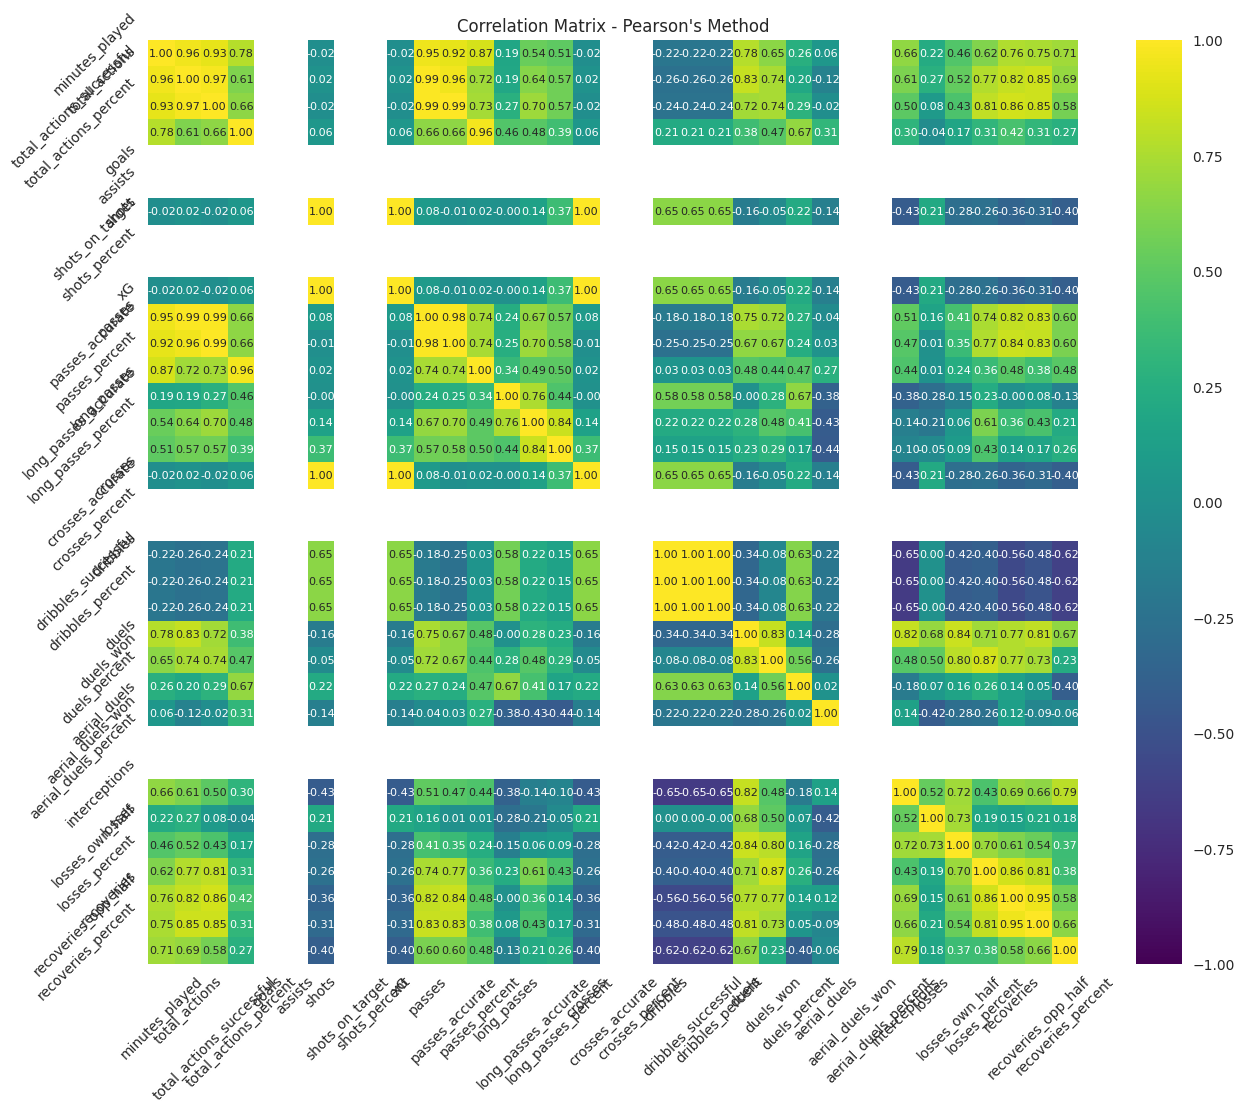

In [ ]:
# Calculating the Pearson correlation matrix
pearson_corr_matrix = test_df.corr(method='pearson')

# Creating a heatmap with the Pearson correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(pearson_corr_matrix, annot=True, fmt=".2f", cmap='viridis', vmax=1, vmin=-1, annot_kws={"size": 8})
plt.title("Correlation Matrix - Pearson's Method")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

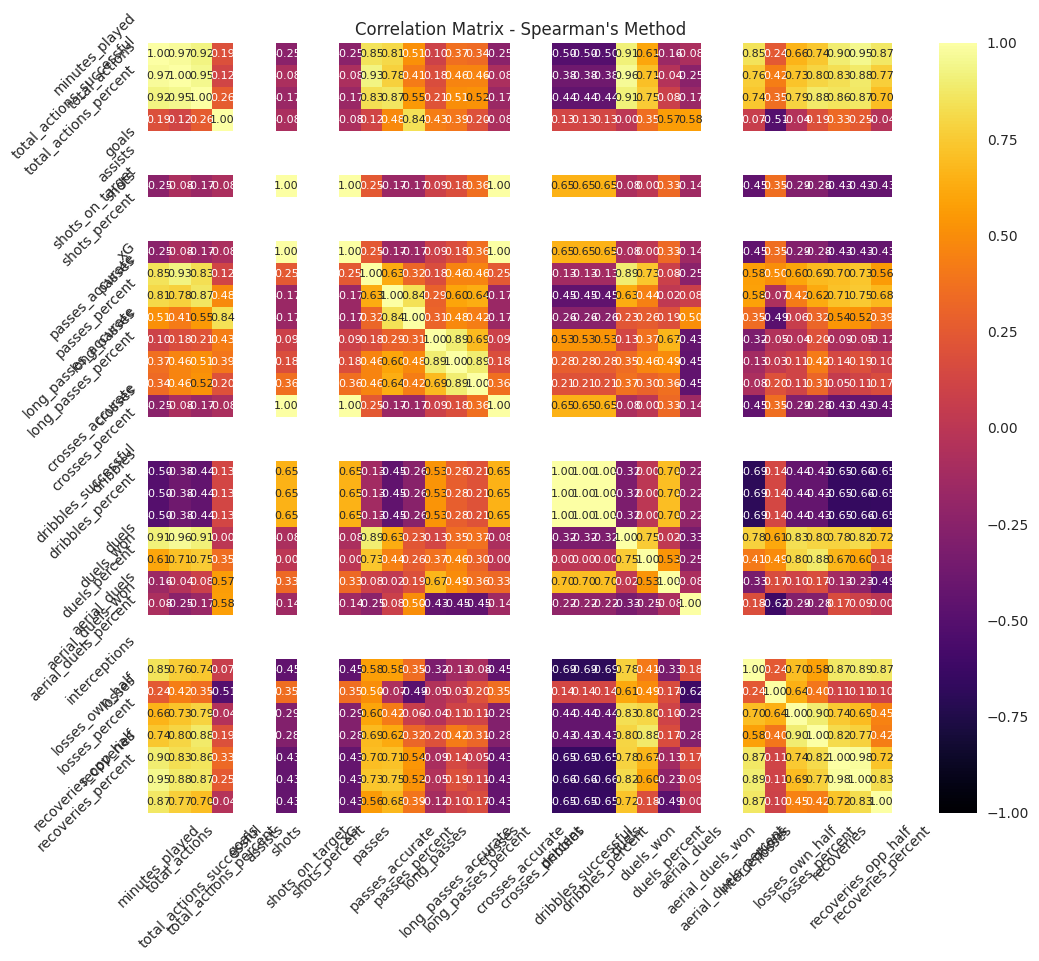

In [ ]:
# Calculating the correlation matrix using Spearman's method
corr_matrix = test_df.corr(method='spearman')

# Adjusting the figure size for better readability
plt.figure(figsize=(12, 10))  # Increase figure size
# Creating a heatmap with the correlation matrix
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='inferno', vmax=1, vmin=-1, annot_kws={"size": 8}) 

plt.title("Correlation Matrix - Spearman's Method")

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=45)  # Rotate y-axis labels for better readability
plt.show()

In [ ]:
# Applying OneHotEncoding
column_to_encode = ['position']

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), column_to_encode)
    ],
    remainder='passthrough'  # Mantener el resto de las columnas sin cambios
)

# Aplicar el ColumnTransformer al DataFrame
transformed_data = preprocessor.fit_transform(test_df)

# Crear un DataFrame a partir de los datos transformados
# Obtener los nombres de las nuevas columnas OneHotEncoded
new_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(column_to_encode)
# Combinar los nombres de las nuevas columnas con las columnas existentes (excluyendo 'position')
all_columns = list(new_columns) + [col for col in test_df.columns if col not in column_to_encode]

# Crear el nuevo DataFrame
test_df = pd.DataFrame(transformed_data, columns=all_columns)

## Test - Feature Engineering

In [ ]:
test_df['passes_duels_ratio'] = test_df['passes_accurate'] / test_df['duels_won'].replace(0, 0.01)
test_df['offense_defense_balance'] = test_df['dribbles_successful'] / test_df['recoveries'].replace(0, 0.01)
test_df['long_passes_aerial_duels'] = test_df['long_passes_accurate'] * test_df['aerial_duels_won']

In [ ]:
# Not Zero-Division Error
test_df['xG'] = test_df['xG'].apply(lambda x: max(x, 0.01))

# Calculting  feature 'shots_per_goal'
test_df['shots_per_goal'] = test_df['shots_on_target'] / test_df['xG']

In [ ]:
for col in test_df.select_dtypes(include=[np.number]).columns:
    if np.any(np.isinf(test_df[col])):
        print(f"Infinites found in {col}")

In [ ]:
from sklearn.impute import SimpleImputer

# Invoking & storage theSimpleImputer
imputer = SimpleImputer(strategy='median')
# Applying on DataFrame
test_df_imputed = imputer.fit_transform(test_df)

# Setting the DataFrame
test_df = pd.DataFrame(test_df_imputed, columns=test_df.columns)

In [ ]:
# Checking Changes
print(df.head())

   position_AMF  position_AMF, LDMF  position_AMF, LW  position_DMF  \
0           0.0                 0.0               0.0           0.0   
1           0.0                 0.0               0.0           0.0   
2           0.0                 0.0               0.0           0.0   
3           0.0                 0.0               0.0           0.0   
4           1.0                 0.0               0.0           0.0   

   position_DMF, RDMF  position_LAMF, LCMF3, RCMF3  position_LCMF  \
0                 0.0                          0.0            0.0   
1                 0.0                          0.0            0.0   
2                 0.0                          0.0            0.0   
3                 0.0                          0.0            0.0   
4                 0.0                          0.0            0.0   

   position_LCMF, LCMF3  position_LCMF, RCMF3  position_LCMF3  ...  losses  \
0                   0.0                   0.0             1.0  ...    10.0   
1 

## Test - Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

target = 'passes'

# Splitting the dataset into features and target
X = test_df.drop(columns=[target])
y = test_df[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    print("There are NaN or infinite values en X_train")
if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    print("There are NaN or infinite values en X_test")

In [ ]:
# Creating a custom transformer to handle infinite values
def replace_inf(X):
    X = np.where(np.isinf(X), np.nan, X)
    return X

Best parameters:  {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best score (negative MSE):  -74.0984


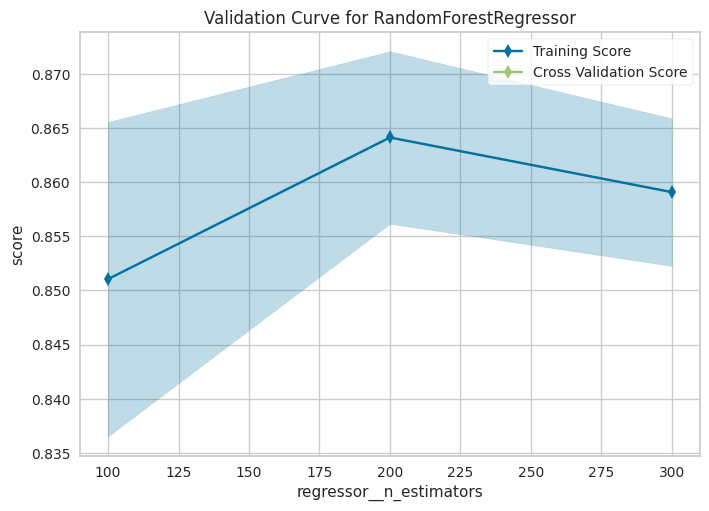

In [ ]:
# Building the pipeline
pipeline = Pipeline([
    ('handle_inf', FunctionTransformer(replace_inf, validate=False)),  # Handle infinite values
    ('imputer', SimpleImputer(strategy='median')),     # Impute missing values
    ('regressor', RandomForestRegressor(random_state=42))   # Regressor - Random Forest
])

# Define the hyperparameter space for grid search
param_grid = {
    'regressor__n_estimators': [200, 300, 500],
    'regressor__max_depth': [5, 10, 20, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt'],
    # 'regressor__bootstrap': [True, False]  # Optional
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)


# Best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score (negative MSE): ", grid_search.best_score_)

# Validation curves with Yellowbrick
val_curve = ValidationCurve(
    pipeline, param_name="regressor__n_estimators",  # Model and parameter to vary
    param_range=[100, 200, 300], cv=5, scoring="r2"  # Range of parameter values and scoring metric
)
val_curve.fit(X_train, y_train)  # Fitting the model
val_curve.show()  # Display the validation curve
plt.show()

- Test

In [ ]:
# Define the model with the best hyperparameters identified from GridSearchCV
best_model = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',  
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    random_state=42  
)

# Train the model using the full training set
best_model.fit(X_train, y_train)

# Evaluate the model using the test set
r2_score = best_model.score(X_test, y_test)
print(f'R^2 score on the test set: {r2_score}')

R^2 score on the test set: -1.6483170971709717


### Test - XGBoost

In [ ]:
# DataFrame Mandatory Copy
test_dfx = test_df.copy()
test_dfx

position_CF  position_LAMF, LCMF  position_LCMF, LW, RW  position_LCMF3  \
0          0.0                  0.0                    0.0             0.0   
1          0.0                  0.0                    0.0             0.0   
2          0.0                  1.0                    0.0             0.0   
3          1.0                  0.0                    0.0             0.0   
4          0.0                  0.0                    1.0             0.0   
5          0.0                  0.0                    0.0             1.0   
6          0.0                  0.0                    0.0             0.0   
7          0.0                  0.0                    0.0             0.0   

   position_LW  position_LW, RCMF  minutes_played  total_actions  \
0          1.0                0.0             2.0            1.0   
1          1.0                0.0            16.0           12.0   
2          0.0                0.0            28.0           32.0   
3          0.0                0.0            24.0           20.0   
4          0.0                0.0            27.0           28.0   
5          0.0                0.0            22.0           25.0   
6          1.0                0.0            25.0           28.0   
7          0.0                1.0            36.0           49.0   

   total_actions_successful  total_actions_percent  ...  losses  \
0                       0.0                    0.0  ...     1.0   
1                      10.0                   83.0  ...     1.0   
2                      20.0                   63.0  ...     6.0   
3                      18.0                   90.0  ...     0.0   
4                      19.0                   68.0  ...     1.0   
5                      18.0                   72.0  ...     3.0   
6                      22.0                   79.0  ...     3.0   
7                      42.0                   86.0  ...     1.0   

   losses_own_half  losses_percent  recoveries  recoveries_opp_half  \
0              0.0             0.0         0.0                  0.0   
1              0.0             0.0         0.0                  0.0   
2              2.0            33.0         4.0                  3.0   
3              0.0             0.0         3.0                  1.0   
4              0.0             0.0         1.0                  1.0   
5              0.0             0.0         0.0                  0.0   
6              2.0            67.0         3.0                  1.0   
7              1.0           100.0         7.0                  5.0   

   recoveries_percent  passes_duels_ratio  offense_defense_balance  \
0                 0.0                 0.0                      0.0   
1                 0.0                 4.0                    100.0   
2                75.0                 4.0                      0.0   
3                33.0                17.0                      0.0   
4               100.0              1800.0                      0.0   
5                 0.0                 8.0                    100.0   
6                33.0                 4.5                      0.0   
7                71.0                 7.4                      0.0   

   long_passes_aerial_duels  shots_per_goal  
0                       0.0             0.0  
1                       0.0             0.0  
2                       0.0             0.0  
3                       0.0             0.0  
4                       0.0             0.0  
5                       0.0             0.0  
6                       0.0             0.0  
7                       0.0             0.0  

[8 rows x 45 columns]

In [ ]:
test_dfx.isnull().sum()

position_CF                 0
position_LAMF, LCMF         0
position_LCMF, LW, RW       0
position_LCMF3              0
position_LW                 0
position_LW, RCMF           0
minutes_played              0
total_actions               0
total_actions_successful    0
total_actions_percent       0
goals                       0
assists                     0
shots                       0
shots_on_target             0
shots_percent               0
xG                          0
passes                      0
passes_accurate             0
passes_percent              0
long_passes                 0
long_passes_accurate        0
long_passes_percent         0
crosses                     0
crosses_accurate            0
crosses_percent             0
dribbles                    0
dribbles_successful         0
dribbles_percent            0
duels                       0
duels_won                   0
duels_percent               0
aerial_duels                0
aerial_duels_won            0
aerial_due

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Setting New DataFrame
X = test_dfx.drop('passes', axis=1)
y = test_dfx['passes']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)



# Pipeline Setting
pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror'))
])

from sklearn.model_selection import GridSearchCV

# Configuration of parameters for search
parameters = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    # Other parameters
}

grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)

# Extracting the best score
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3}
Best Score: nan


In [ ]:
print(np.isfinite(X_train).all())
print(np.isfinite(y_train).all())


position_CF                 True
position_LAMF, LCMF         True
position_LCMF, LW, RW       True
position_LCMF3              True
position_LW                 True
position_LW, RCMF           True
minutes_played              True
total_actions               True
total_actions_successful    True
total_actions_percent       True
goals                       True
assists                     True
shots                       True
shots_on_target             True
shots_percent               True
xG                          True
passes_accurate             True
passes_percent              True
long_passes                 True
long_passes_accurate        True
long_passes_percent         True
crosses                     True
crosses_accurate            True
crosses_percent             True
dribbles                    True
dribbles_successful         True
dribbles_percent            True
duels                       True
duels_won                   True
duels_percent               True
aerial_due

Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3}
Best Score: nan


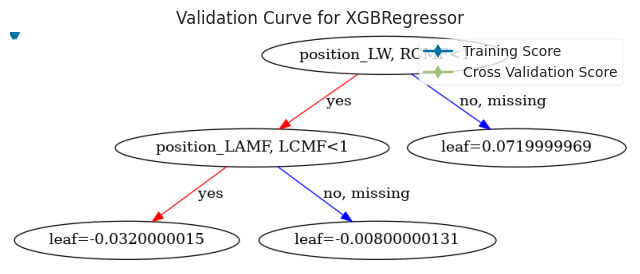

In [ ]:
from yellowbrick.model_selection import ValidationCurve
import xgboost as xgb

# Visualization of the tree
xgb.plot_tree(grid_search.best_estimator_['xgb'], num_trees=0)

# Validation Curve
viz = ValidationCurve(
    XGBRegressor(objective='reg:squarederror'), param_name="max_depth",
    param_range=[3, 5, 7], cv=3, scoring="r2"
)
viz.fit(X_train, y_train)
viz.show()
plt.show()

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

MSE: 160.74021509388695
R^2: -1.6691179628136208


### Test - Regressor Optimized

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score


X = test_dfx.drop('passes', axis=1)
y = test_dfx['passes']

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Pipeline Setting with preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale features
])

# Column transformer for different types of features if you have categorical features as well
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('cat', categorical_transformer, categorical_features)  # Add this if you have categorical features
    ])

# Pipeline with preprocessing and XGBoost regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Configuration of parameters for search
parameters = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__n_estimators': [100, 200, 300]  # Additional hyperparameter for tuning
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Extracting the best parameters
best_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)

# Extracting the best score
best_score = -grid_search.best_score_  # Negate because scoring is negative MSE
print("Best Score:", best_score)

# Evaluating on the test set with the best found model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate MSE and R^2 on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print("Test MSE:", test_mse)
print("Test R^2:", test_r2)


Best Parameters: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Score: 55.33809449818
Test MSE: 135.33445740166644
Test R^2: -1.2472511376660478


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Rebuilding the model with the identified best hyperparameters
best_learning_rate = 0.1
best_max_depth = 3

# Setting up the pipeline with the optimized XGBRegressor
optimized_pipeline = Pipeline([
    ('xgb', XGBRegressor(objective='reg:squarederror', 
                         learning_rate=best_learning_rate, 
                         max_depth=best_max_depth))
])

# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Predicting on the test data
y_pred = optimized_pipeline.predict(X_test)

# Evaluating the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 135.37499560312912
R^2 Score: -1.247924281232771


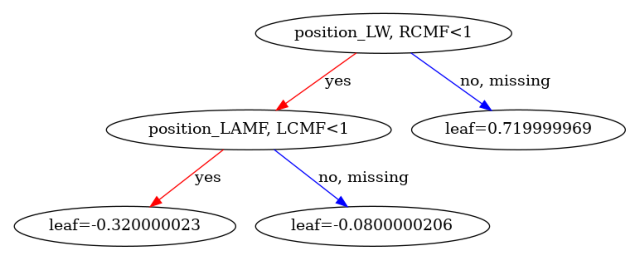

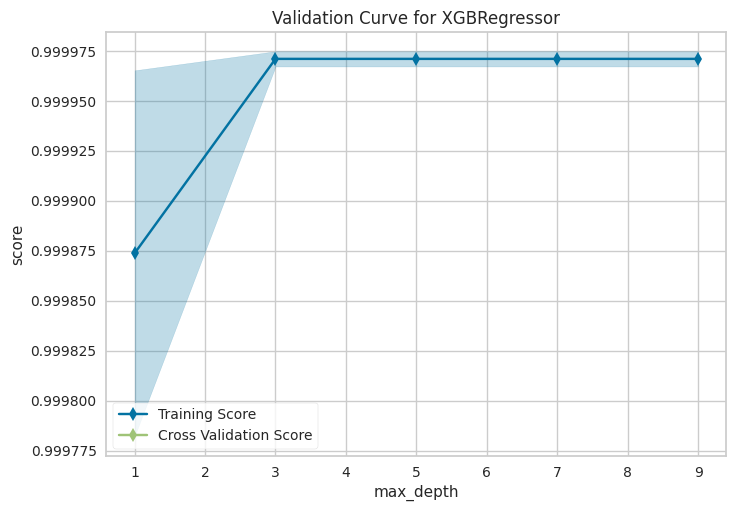

In [ ]:
# Fitting the optimized model to the training data
optimized_pipeline.fit(X_train, y_train)

# Visualizing the first tree of the model
xgb_model = optimized_pipeline.named_steps['xgb']
xgb.plot_tree(xgb_model, num_trees=0)
plt.show()

# Creating a Validation Curve
# Here, we are using 'max_depth' as the parameter for the validation curve.
# You can change this to another parameter if desired.
viz = ValidationCurve(
    XGBRegressor(objective='reg:squarederror', learning_rate=best_learning_rate),
    param_name="max_depth",
    param_range=[1, 3, 5, 7, 9],  # Adjust this range based on your needs
    cv=3,
    scoring="r2"
)

viz.fit(X_train, y_train)
viz.show()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b61260b4-df23-4e75-9771-c9b64e9f101e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>